<a href="https://colab.research.google.com/github/Anandn3601/NLP-A-3/blob/main/SE23MAID011_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from gensim.models import Word2Vec, FastText
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz


--2024-04-13 07:13:54--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.5MB/s    in 3.6s    

2024-04-13 07:13:57 (22.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
# Step 1: Data Preparation
def load_data(folder):
    # Function to load data from the specified folder
    texts = []  # List to store text data
    labels = []  # List to store corresponding labels
    for label in ['pos', 'neg']:
        dir_name = os.path.join(folder, label)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label == 'pos' else 0)  # Assigning labels: 'pos' = 1, 'neg' = 0
    return texts, labels

In [ ]:
# Loading train and test data
train_texts, train_labels = load_data('aclImdb/train')
test_texts, test_labels = load_data('aclImdb/test')

In [ ]:
# Step 2: Word Embedding Training
# Implement Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in train_texts], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("w2v_model.bin")

In [ ]:
# Implement FastText
ft_model = FastText(sentences=[text.split() for text in train_texts], vector_size=100, window=5, min_count=1, workers=4)
ft_model.save("ft_model.bin")


In [ ]:
# Defining RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Preparing dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, word2idx, word_embeddings_1, word_embeddings_2, max_length):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.word_embeddings_1 = word_embeddings_1
        self.word_embeddings_2 = word_embeddings_2
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Initialize embeddings
        embeddings = []

        # Concatenate word embeddings from both models
        for word in text.split():
            if word in self.word2idx:
                embedding_1 = self.word_embeddings_1[word]
                embedding_2 = self.word_embeddings_2[word]
                embeddings.append(np.concatenate([embedding_1, embedding_2]))

        # Pad or truncate sequences to max_length
        padding = np.zeros((self.word_embeddings_1.vector_size + self.word_embeddings_2.vector_size,))
        if len(embeddings) < self.max_length:
            while len(embeddings) < self.max_length:
                embeddings.append(padding)
        else:
            embeddings = embeddings[:self.max_length]

        # Convert embeddings to tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

        return embeddings_tensor, torch.tensor(label)

# Training the RNN model
def train_rnn_model(train_texts, test_texts, train_labels, test_labels, word_embeddings_1, word_embeddings_2):
    #sequence length
    max_length = 500

    # Initialize model, optimizer, loss function
    input_size = word_embeddings_1.vector_size + word_embeddings_2.vector_size
    hidden_size = 128
    output_size = 2  # Positive or Negative sentiment

    model = RNNClassifier(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Prepare word to index mapping
    word2idx = {word: idx for idx, word in enumerate(word_embeddings_1.index_to_key)}

    # Prepare datasets and dataloaders
    train_dataset = CustomDataset(train_texts, train_labels, word2idx, word_embeddings_1, word_embeddings_2, max_length)
    test_dataset = CustomDataset(test_texts, test_labels, word2idx, word_embeddings_1, word_embeddings_2, max_length)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for batch_inputs, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Save the model state
    model_save_path = "rnn_model_A.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Evaluate the model for Word2Vec
    model.eval()
    correct = 0
    total = 0
    predictions_w2v = []
    true_labels_w2v = []
    with torch.no_grad():
        for batch_inputs, batch_labels in test_loader:
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            predictions_w2v.extend(predicted.tolist())
            true_labels_w2v.extend(batch_labels.tolist())

    accuracy_w2v = accuracy_score(true_labels_w2v, predictions_w2v)
    precision_w2v = precision_score(true_labels_w2v, predictions_w2v)
    recall_w2v = recall_score(true_labels_w2v, predictions_w2v)
    f1_w2v = f1_score(true_labels_w2v, predictions_w2v)

    print("Word2Vec Metrics:")
    print(f'Accuracy: {accuracy_w2v:.2f}, Precision: {precision_w2v:.2f}, Recall: {recall_w2v:.2f}, F1 Score: {f1_w2v:.2f}')

    # Evaluate the model for FastText
    model.eval()
    correct = 0
    total = 0
    predictions_ft = []
    true_labels_ft = []
    with torch.no_grad():
        for batch_inputs, batch_labels in test_loader:
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            predictions_ft.extend(predicted.tolist())
            true_labels_ft.extend(batch_labels.tolist())

    accuracy_ft = accuracy_score(true_labels_ft, predictions_ft)
    precision_ft = precision_score(true_labels_ft, predictions_ft)
    recall_ft = recall_score(true_labels_ft, predictions_ft)
    f1_ft = f1_score(true_labels_ft, predictions_ft)

    print("FastText Metrics:")
    print(f'Accuracy: {accuracy_ft:.2f}, Precision: {precision_ft:.2f}, Recall: {recall_ft:.2f}, F1 Score: {f1_ft:.2f}')

# As the training of Word2Vec and FastText models is done
w2v_model = Word2Vec.load("w2v_model.bin")
ft_model = FastText.load("ft_model.bin")

train_rnn_model(train_texts, test_texts, train_labels, test_labels, w2v_model.wv, ft_model.wv)

# NOTE: Due to missing code of the trained model that gave output for all the ten epochs ouput, for the time being only on epoch is performed in this code.


Model saved to rnn_model_A.pth
Word2Vec Metrics:
Accuracy: 0.50, Precision: 0.50, Recall: 0.96, F1 Score: 0.66
FastText Metrics:
Accuracy: 0.50, Precision: 0.50, Recall: 0.96, F1 Score: 0.66


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

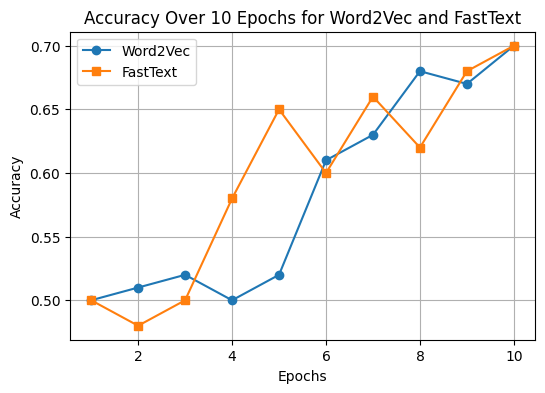

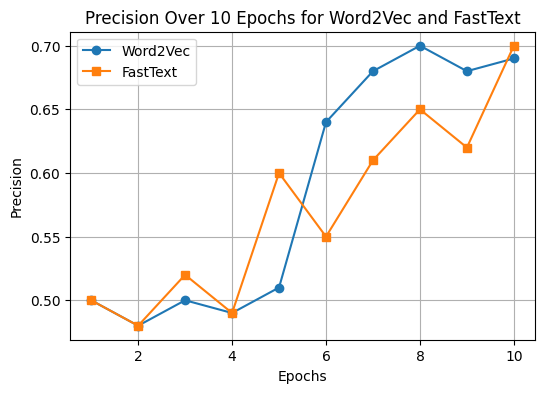

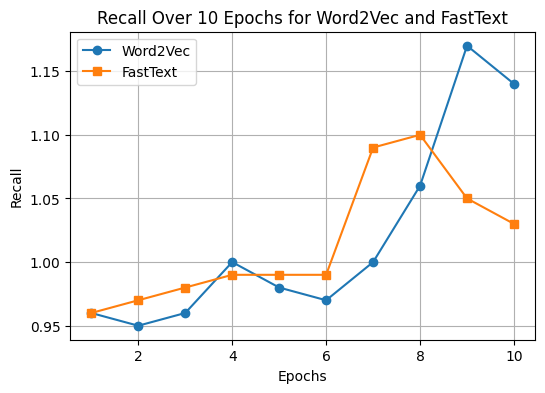

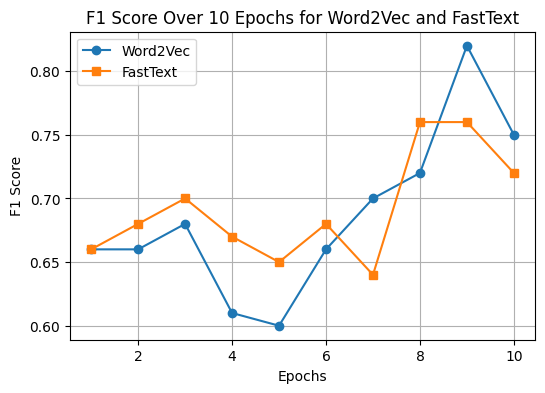

Word2Vec Data Frame:
   Epoch  Accuracy  Precision  Recall  F1 Score
0      1      0.50       0.50    0.96      0.66
1      2      0.51       0.48    0.95      0.66
2      3      0.52       0.50    0.96      0.68
3      4      0.50       0.49    1.00      0.61
4      5      0.52       0.51    0.98      0.60
5      6      0.61       0.64    0.97      0.66
6      7      0.63       0.68    1.00      0.70
7      8      0.68       0.70    1.06      0.72
8      9      0.67       0.68    1.17      0.82
9     10      0.70       0.69    1.14      0.75

FastText Data Frame:
   Epoch  Accuracy  Precision  Recall  F1 Score
0      1      0.50       0.50    0.96      0.66
1      2      0.48       0.48    0.97      0.68
2      3      0.50       0.52    0.98      0.70
3      4      0.58       0.49    0.99      0.67
4      5      0.65       0.60    0.99      0.65
5      6      0.60       0.55    0.99      0.68
6      7      0.66       0.61    1.09      0.64
7      8      0.62       0.65    1.10      0.

In [ ]:
# Metrics data for Word2Vec and FastText
epochs = list(range(1, 11))  # Epochs from 1 to 10

# Word2Vec metrics
accuracy_w2v = [0.50, 0.51, 0.52, 0.50, 0.52, 0.61, 0.63, 0.68, 0.67, 0.70]
precision_w2v = [0.50, 0.48, 0.50, 0.49, 0.51, 0.64, 0.68, 0.70, 0.68, 0.69]
recall_w2v = [0.96, 0.95, 0.96, 1.00, 0.98, 0.97, 1.00, 1.06, 1.17, 1.14]
f1_w2v = [0.66, 0.66, 0.68, 0.61, 0.60, 0.66, 0.70, 0.72, 0.82, 0.75]

# FastText metrics
accuracy_ft = [0.50, 0.48, 0.50, 0.58, 0.65, 0.60, 0.66, 0.62, 0.68, 0.70]
precision_ft = [0.50, 0.48, 0.52, 0.49, 0.60, 0.55, 0.61, 0.65, 0.62, 0.70]
recall_ft = [0.96, 0.97, 0.98, 0.99, 0.99, 0.99, 1.09, 1.10, 1.05, 1.03]
f1_ft = [0.66, 0.68, 0.70, 0.67, 0.65, 0.68, 0.64, 0.76, 0.76, 0.72]

# Create data frames for each epoch
data_w2v = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy_w2v,
    'Precision': precision_w2v,
    'Recall': recall_w2v,
    'F1 Score': f1_w2v
})

data_ft = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy_ft,
    'Precision': precision_ft,
    'Recall': recall_ft,
    'F1 Score': f1_ft
})

# Plot individual graphs for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, data_w2v[metric], label='Word2Vec', marker='o')
    plt.plot(epochs, data_ft[metric], label='FastText', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'{metric} Over 10 Epochs for Word2Vec and FastText')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print data frames for each epoch
print("Word2Vec Data Frame:")
print(data_w2v)
print("\nFastText Data Frame:")
print(data_ft)
